Now we have a features.csv! Good Work Ani!

Time to do some EDA and model making 

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np 

In [2]:
df = pd.read_csv("/Users/r3alistic/Programming/CoffeeCV/features.csv")
df.head()

,Video_Name,Category,Avg_Hue,Avg_Brightness,Pull_Duration,Flow_Variance,Avg_Stream_Width
0,vid_14_good,good,32.14,119.23,27.28,6.481446,672.993939
1,vid_22_good,good,35.57,125.05,25.65,5.425358,536.084848
2,vid_19_good,good,35.80,121.09,25.41,1.345650,329.800000
3,vid_1_good,good,30.46,127.24,13.75,3.486998,749.745455
4,vid_15_good,good,30.81,113.55,24.05,3.563808,781.863636


Right now there are no missing values, but just drop them if there are.

Now just for sanity, check for duplicates

In [3]:
len(df["Video_Name"]) == len(set(df["Video_Name"]))

True

In [4]:
len(df["Video_Name"])

46

What is some EDA visualization that I can do?

Maybe I can do boxplots and historgrams for each category. I can see the central tendencies for our numerics

array([[<Axes: title={'center': 'Avg_Hue'}>,
        <Axes: title={'center': 'Avg_Brightness'}>],
       [<Axes: title={'center': 'Pull_Duration'}>,
        <Axes: title={'center': 'Flow_Variance'}>],
       [<Axes: title={'center': 'Avg_Stream_Width'}>, <Axes: >]],
      dtype=object)

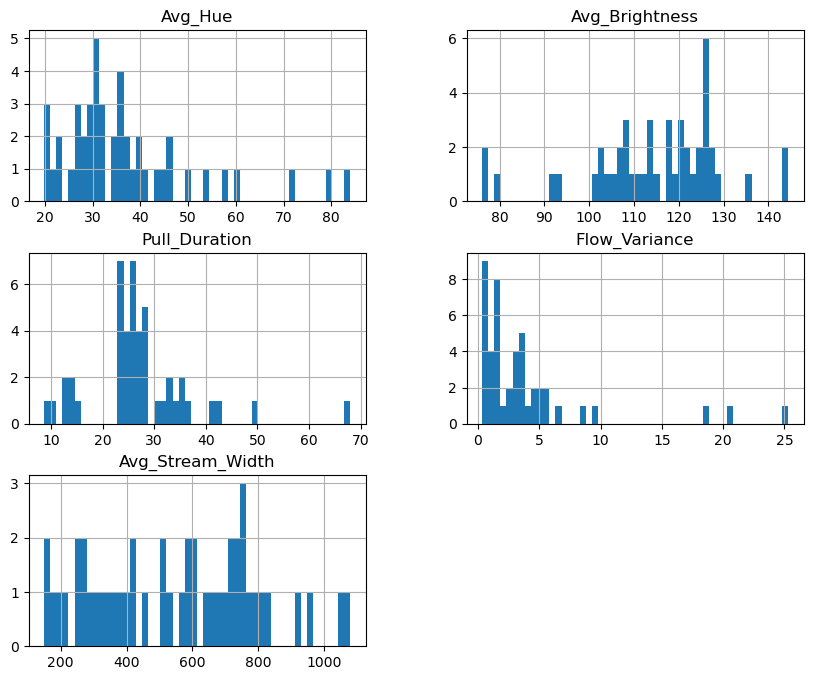

In [5]:
df[["Avg_Hue","Avg_Brightness","Pull_Duration","Flow_Variance","Avg_Stream_Width"]].hist(bins=50,figsize=(10,8))

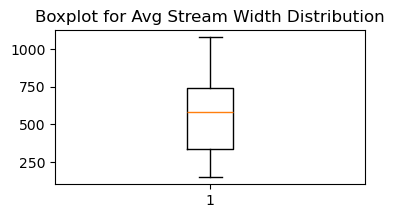

In [6]:
plt.figure(figsize=(4,2))
plt.boxplot(df["Avg_Stream_Width"])
plt.title("Boxplot for Avg Stream Width Distribution")
plt.show()

Idea: check the average stream width for each category, so use groupby

In [7]:
df.describe()

,Avg_Hue,Avg_Brightness,Pull_Duration,Flow_Variance,Avg_Stream_Width
count,46.000000,46.000000,46.000000,46.000000,46.000000
mean,37.171304,114.685652,27.277174,3.938189,549.287685
std,14.505582,15.010079,10.135076,5.188554,250.140097
min,19.810000,76.080000,8.640000,0.330238,148.733333
25%,28.620000,107.050000,24.020000,1.077348,334.150000
50%,33.075000,117.695000,26.065000,2.516364,582.474242
75%,40.932500,125.447500,29.872500,4.548870,740.025758
max,83.960000,144.440000,68.000000,25.313041,1080.000000


# Train Test Split

(Even with an abysmally low amount of data)

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Separate features and target
X = df.drop(columns=["Category", "Video_Name"])
y = df["Category"].to_numpy()

# Encode target labels as integers (ex: good = 0, under = 1, over = 2). OneHotEncoder would be too much here. Just labels in the same column is fine
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Scale numeric features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
#and then on new data, just .transform()

# Split the data (use scaled X!)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

Previously, the label encoder gave an error because "over" only had one video, and we need at least 2. So we fixed that hehe. And stratifying makes it even better. 

So now let's make a bare bones Classification model

# Model Building

In [9]:
from sklearn.linear_model import LogisticRegression, RidgeClassifier

In [10]:
#model object
logReg = LogisticRegression()

#train the model
logReg.fit(X_train,y_train)

y_pred_train_logReg = logReg.predict(X_train)

Let's get some training scores

In [11]:
from sklearn.metrics import confusion_matrix,accuracy_score,f1_score

In [12]:
cm = confusion_matrix(y_train,y_pred_train_logReg)

In [13]:
import seaborn as sns

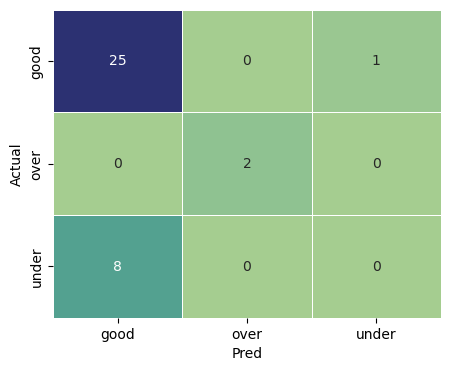

In [14]:
plt.figure(figsize=(5,4))
sns.heatmap(cm,annot=True,cmap="crest",linewidth=0.5,xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_,cbar=False)
plt.xlabel("Pred")
plt.ylabel("Actual")
plt.show()

In [15]:
accuracy_score(y_train,y_pred_train_logReg)

0.75

f1_score is good for binary only I think

So what all did I learn? 
- Label Encoder will help with simple 0,1,2 , but you need at least 2 in each category
- Label Encoder Object has an attribute that comes after fitting called .classes_ , and it gives an array of the classes. So I used that in the heatmap for accurate labeling. 
- l2 regularization is the default for Logistic Regression
- My data pipeline and feature engine is duplicate-proof and will overwrite correctly!
- This bare bones LogReg has a low train score. More work is needed to be done

Let's try Ridge Classifier

In [16]:
#model object
ridgeC = RidgeClassifier()

#train the model
ridgeC.fit(X_train,y_train)

y_pred_train_ridge = ridgeC.predict(X_train)

### Seaborn cmap cheat sheet

| Name        | Description                         | Preview                    |
| ----------- | ----------------------------------- | -------------------------- |
| `"viridis"` | perceptually uniform, great default | 🔰 smooth green → yellow   |
| `"plasma"`  | bright purples and yellows          | 🔮 purple → orange/yellow  |
| `"inferno"` | dark red to yellow                  | 🔥 black → red → yellow    |
| `"magma"`   | dark purple to yellow               | 🌋 black → purple → yellow |
| `"crest"`   | cool teal/blue to soft purple       | 🌊 seafoam → violet        |
| `"flare"`   | bright warm tones                   | 🌅 red → orange → yellow   |
| `"rocket"`  | darker version of flare             | 🚀 black → red → pink      |


| Name         | Description                     | Preview      |
| ------------ | ------------------------------- | ------------ |
| `"coolwarm"` | blue → white → red              | ❄️  → ⚪ → 🔥 |
| `"seismic"`  | blue → white → red (stronger)   | 🌊  → ⚪ → 🌋 |
| `"vlag"`     | soft blue to soft red           | 🩵  → ⚪ → 🩷 |
| `"icefire"`  | cool to warm with high contrast | 🧊  → ⚪ → 🔥 |


| Name        | Description                  |
| ----------- | ---------------------------- |
| `"tab10"`   | 10 distinct colors (default) |
| `"Set1"`    | bright, bold colors          |
| `"Set2"`    | softer, muted colors         |
| `"Pastel1"` | soft pastel tones            |
| `"Dark2"`   | deeper, high-contrast colors |


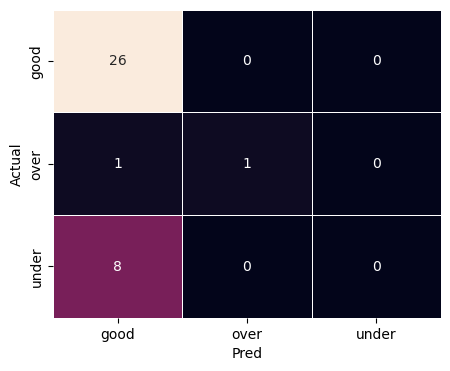

In [17]:
cm2 = confusion_matrix(y_train,y_pred_train_ridge)

plt.figure(figsize=(5,4))
sns.heatmap(cm2,annot=True,cmap="rocket",linewidth=0.5,xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_,cbar=False)
plt.xlabel("Pred")
plt.ylabel("Actual")
plt.show()

In [18]:
accuracy_score(y_train,y_pred_train_ridge)

0.75

Since we have such less amount of data, it might be good to do GridSearchCV

In [19]:
from sklearn.model_selection import GridSearchCV

In [20]:
param_grid_logReg = {
    "C":[0.01,0.1,1.0,10]
}

grid = GridSearchCV(estimator=logReg,param_grid=param_grid_logReg,cv=3,n_jobs=-1,scoring="accuracy")

grid.fit(X_train,y_train)

y_pred_train_grid_lr = grid.best_estimator_.predict(X_train)

/opt/anaconda3/envs/coffeecv/lib/python3.11/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


We need more overextracted for better results

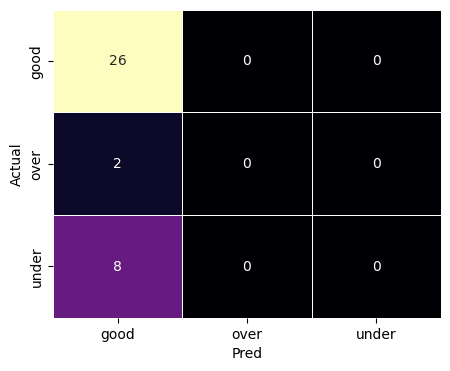

In [21]:
cm3 = confusion_matrix(y_train,y_pred_train_grid_lr)

plt.figure(figsize=(5,4))
sns.heatmap(cm3,annot=True,cmap="magma",linewidth=0.5,xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_,cbar=False)
plt.xlabel("Pred")
plt.ylabel("Actual")
plt.show()

In [ ]:
accuracy_score(y_train,y_pred_train_grid_lr)

0.7222222222222222

Hahaaaaaaa we terrible rn 